In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from src.ForecastModel.utils.metrics import calculate_nse, calculate_kge, calculate_bias
from src.ForecastModel.utils.postprocessing import ModelHandler, find_best_models

import numpy as np
import pandas as pd

import json

# plot styling
plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

In [2]:
PLOT_PATH = r"plots"
DATA_PATH = r"src\data\Dataset.csv"

In [3]:
models = {
    "arima": ModelHandler("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "#E69F00",
                ls = "--",
                  ),
    "arimax": ModelHandler("ARIMAX",
                r"rst\ARIMAX",
                is_final_model = True,
                is_external_model = True,
                color = "#0072B2",
                ls = "--",
                  ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
                   r"rst\PBHM-HLSTM",
                   is_final_model = True,
                   color = "#56B4E9",
                   ls = "-",
                 ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = "#D55E00",
                   ls = "-",
                 ),
     "lstm": ModelHandler("LSTM",
                   r"rst\LSTM",
                   is_final_model = True,
                   color = "#CC79A7",
                   ls = "-",
                 ),
     }


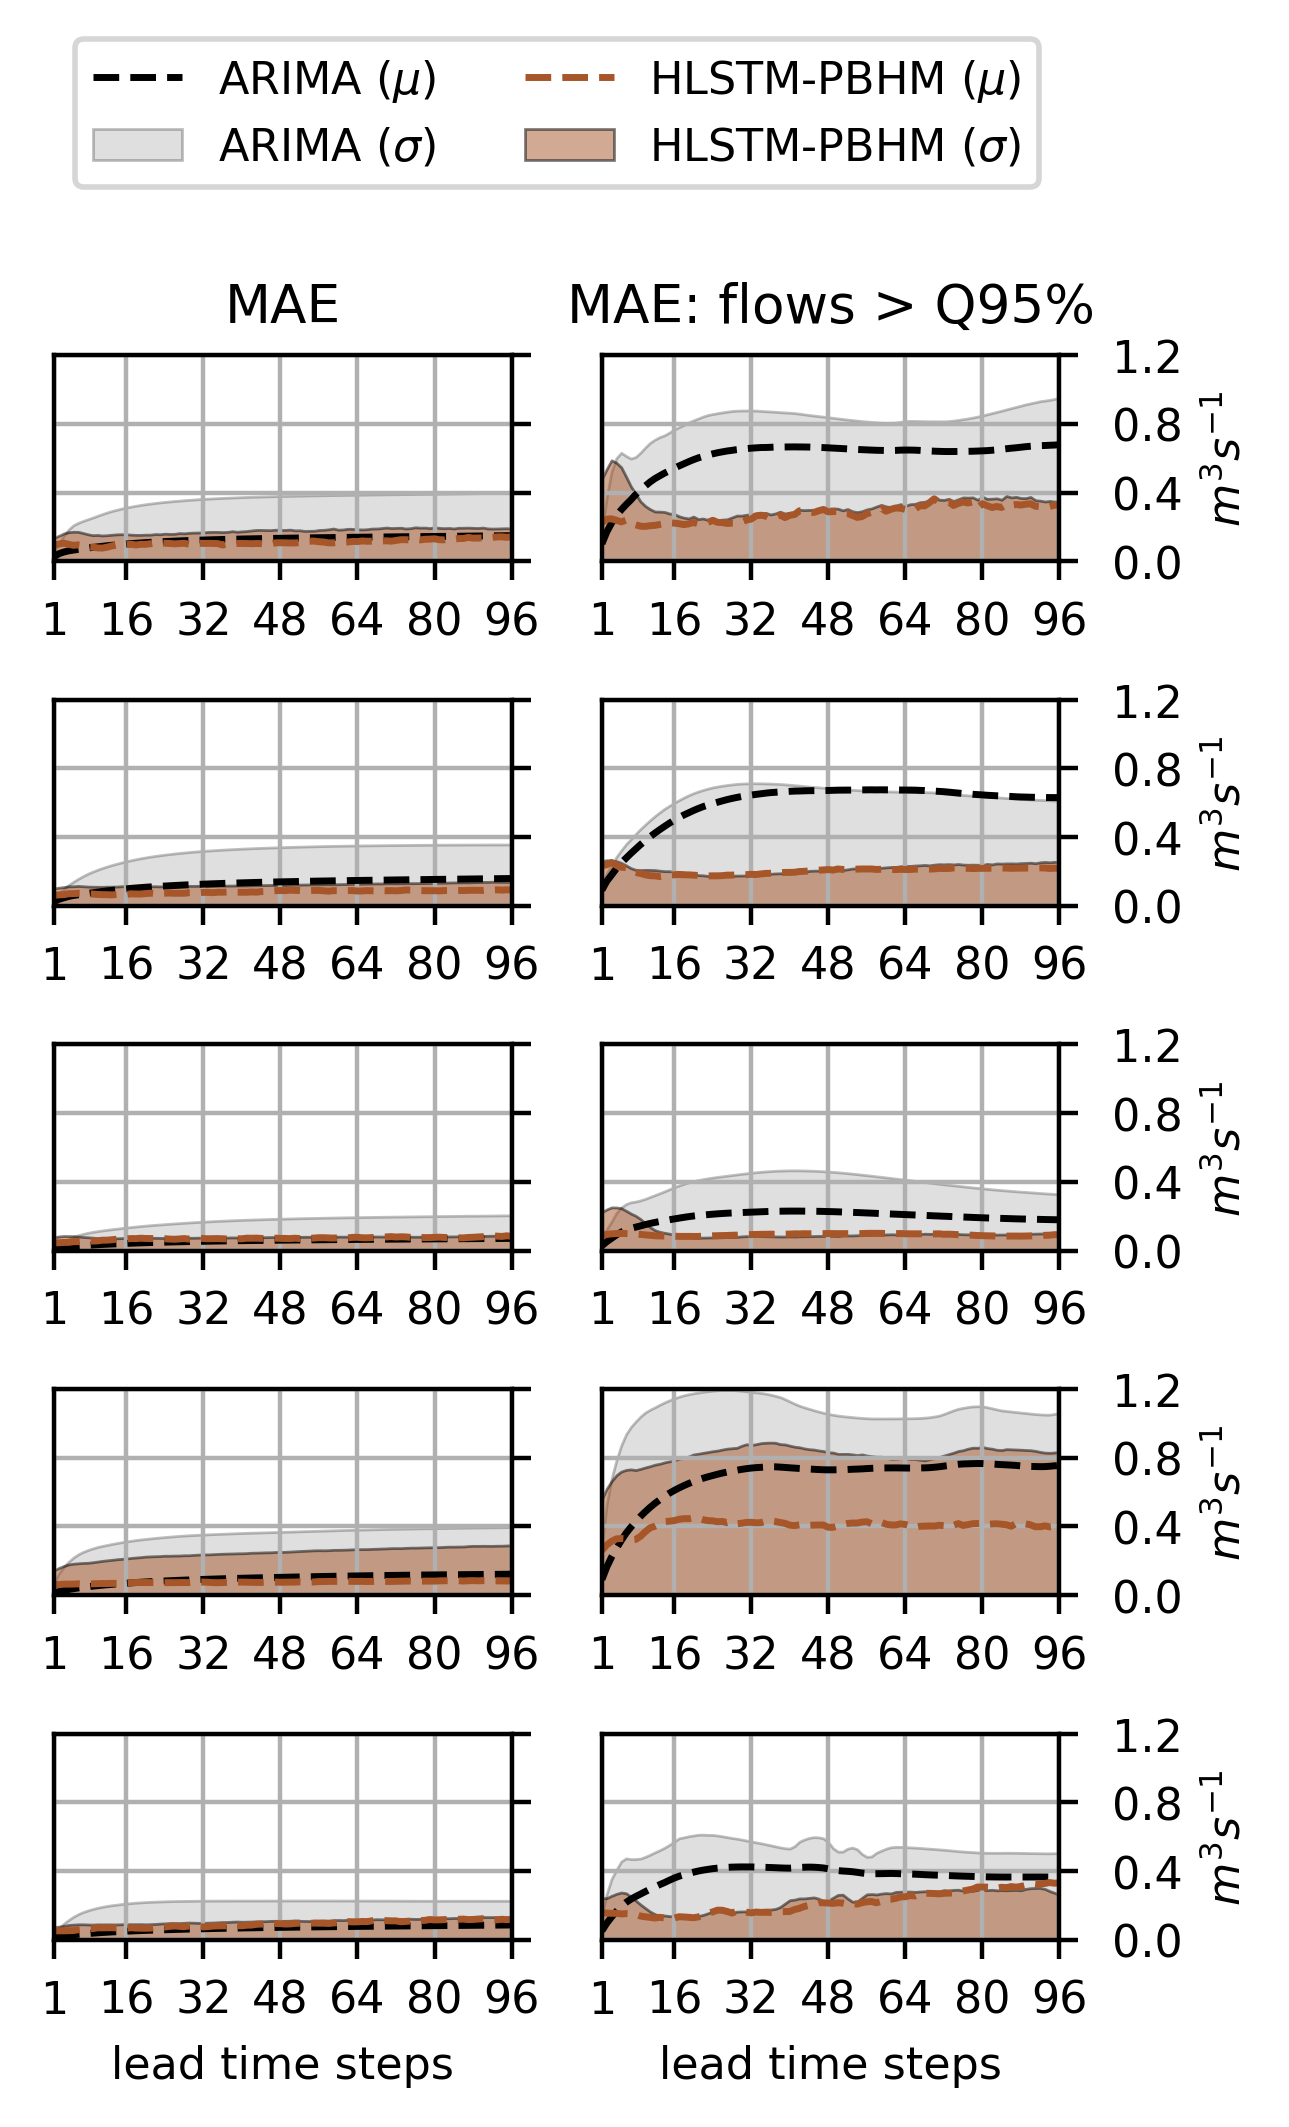

In [18]:
# create summary dataframe
df = pd.DataFrame(index=np.arange(2013,2018,dtype=int))

# process all folds
filepaths_lstm = [os.path.join(models["pbhm-hlstm"].lg_path, f"forecast_{x:d}.pkl") for x in range(2013,2018)]
filepaths_arima = [os.path.join(models["arima"].lg_path, f"forecast_{x:d}.pkl") for x in range(2013,2018)]

date_ranges = [['2013-01-06 00:00:00','2013-12-27 00:00:00'],
               ['2014-01-06 00:00:00','2014-12-27 00:00:00'],
               ['2015-01-06 00:00:00','2015-12-27 00:00:00'],
               ['2016-01-06 00:00:00','2016-12-27 00:00:00'],
               ['2017-01-06 00:00:00','2017-12-27 00:00:00']]

fig, axes = plt.subplots(5,2,figsize=(4.72*8.3/12,5), dpi=400)

for j in range(2):       
    all_abs_error_folds_arima = []
    all_abs_error_folds_lstm = []
    all_norm_arima = []
    all_norm_hydro = []
    all_norm_lstm = []
    for i in range(0,len(filepaths_lstm)):
        year = 2013 + i

        if j == 0:
            data_lstm = pd.read_pickle(filepaths_lstm[i])
            data_arima = pd.read_pickle(filepaths_arima[i])
            
            # FIX UTC ------------------------------------------------------
            data_arima.index = pd.date_range(data_arima.index[0], data_arima.index[-1], freq="15min", tz="UTC")
        
            data_lstm_filtered = data_lstm.sort_index().loc[date_ranges[i][0]:date_ranges[i][1]]
            data_arima_filtered = data_arima.sort_index().loc[date_ranges[i][0]:date_ranges[i][1]]
        
            all_best_list, normalized_arima, normalized_lstm, all_absolute_errors_arima, all_absolute_errors_lstm = find_best_models(data_lstm_filtered, data_arima_filtered)
        
            all_abs_error_folds_arima.append(all_absolute_errors_arima)
            all_abs_error_folds_lstm.append(all_absolute_errors_lstm)
            all_norm_arima.append(normalized_arima)
            all_norm_lstm.append(normalized_lstm)
    
        else:
            data_lstm = pd.read_pickle(filepaths_lstm[i])
            data_arima = pd.read_pickle(filepaths_arima[i])
        
            # FIX UTC ------------------------------------------------------
            data_arima.index = pd.date_range(data_arima.index[0], data_arima.index[-1], freq="15min", tz="UTC")
        
            # make dfs the same size
            data_lstm  = data_lstm.loc[data_arima.index[0]:data_lstm.index[-2]]
            data_arima = data_arima.loc[:data_lstm.index[-1]]
            
            # top 5% discharge of the year
            peak_discharge_thresh = np.quantile(data_arima.obs0, 0.95)
            mask = data_arima.obs0 >= peak_discharge_thresh
        
            data_lstm_filtered  = data_lstm.loc[mask]
            data_arima_filtered = data_arima.loc[mask]
        
            all_best_list, normalized_arima, normalized_lstm, all_absolute_errors_arima, all_absolute_errors_lstm = find_best_models(data_lstm_filtered, data_arima_filtered)
        
            all_abs_error_folds_arima.append(all_absolute_errors_arima)
            all_abs_error_folds_lstm.append(all_absolute_errors_lstm)
            all_norm_arima.append(normalized_arima)
            all_norm_lstm.append(normalized_lstm)
    
        # percentage of ARIMA wins
        add_up = np.sum(all_best_list, axis=0)
        df.loc[year, "arima_first_step_wins_percent"] = all_best_list[0][0] / np.sum(all_best_list, axis=1)[0]
        df.loc[year, "arima_wins_percent"] = add_up[0] / np.sum(add_up)
        # lead time steps to outperform ARIMA in direct wins
        out_perform_idxs = [n for n, (x,y) in enumerate(all_best_list) if y-x > 0]
        if len(out_perform_idxs) > 0:
            df.loc[year, "wins"]       = out_perform_idxs[0]
            df.loc[year, "wins_hours"] = out_perform_idxs[0]*0.25
        else:
            df.loc[year, "wins"]       = -1
            df.loc[year, "wins_hours"] = -1
        # lead time steps to outperform ARIMA in AE
        out_perform_idxs = [n for n, (x,y) in enumerate(zip(
                np.mean(np.abs(all_absolute_errors_arima), axis=1), 
                np.mean(np.abs(all_absolute_errors_lstm), axis=1)
            )) if y-x < 0]
        if len(out_perform_idxs) > 0:
            df.loc[year, "ae"]       = out_perform_idxs[0]
            df.loc[year, "ae_hours"] = out_perform_idxs[0]*0.25
        else:
            df.loc[year, "ae"]       = -1
            df.loc[year, "ae_hours"] = -1
        # lead time steps to outperform ARIMA in sigma
        out_perform_idxs = [n for n, (x,y) in enumerate(zip(
                np.std(np.abs(all_absolute_errors_arima), axis=1), 
                np.std(np.abs(all_absolute_errors_lstm), axis=1)
            )) if y-x < 0]
        if len(out_perform_idxs) > 0:
            df.loc[year, "sigma"]       = out_perform_idxs[0]
            df.loc[year, "sigma_hours"] = out_perform_idxs[0]*0.25
        else:
            df.loc[year, "sigma"]       = -1
            df.loc[year, "sigma_hours"] = -1
    
    
    num_entries = 96
    
    x_values = np.arange(1,97)
    
    limlist = [[-1.7,5.2],[-0.20,2.6],[-0.32,2.0],[-1.6,5.0],[-1.2,3.6]]
    ticklist = [[-1.5, 0.0, 2.5, 5.0],
                [0.0, 0.8, 1.6, 2.4],
                [0.0, 0.6, 1.2, 1.8],
                [-1.4,0.0,2.4,4.8],
                [-1.0,0.0,1.8,3.6]]
    
    k = 0
    for i in range(0,5):
        
        x = np.arange(1,97)
        y_mean = np.asarray([np.mean(elem) for elem in all_abs_error_folds_arima[k]])
        y_std = np.asarray([np.std(elem) for elem in all_abs_error_folds_arima[k]])
        
        y_mean_lstm = np.asarray([np.mean(elem) for elem in all_abs_error_folds_lstm[k]])
        y_std_lstm = np.asarray([np.std(elem) for elem in all_abs_error_folds_lstm[k]])
        
        axes[i,j].plot(x, y_mean, color= 'black', linestyle = '--', label='ARIMA ($\mu$)', linewidth=1.25)
        axes[i,j].fill_between(x, y_std, y2=0, color='grey', label='ARIMA ($\sigma$)', alpha=0.25, edgecolor='black', linewidth=0.5)
        
        axes[i,j].plot(x, y_mean_lstm, color= '#a65628', linestyle = '--', label='HLSTM-PBHM ($\mu$)', linewidth=1.25)
        axes[i,j].fill_between(x, y_std_lstm, y2=0, color='#a65628', label='HLSTM-PBHM ($\sigma$)', alpha=0.5, edgecolor='black', linewidth=0.5)
        
        axes[i,j].set_xticks(np.array([1,16,32,48,64,80,96]))
        axes[i,j].set_xticks(np.array([1, 16, 32, 48, 64, 80, 96]))
        axes[i,j].set_yticks([0,0.4,0.8,1.2])
        axes[i,j].set_ylim([0,1.2])
        
        axes[i,j].yaxis.set_major_formatter('{x: 4.1f}')
        
        axes[i,j].set_xlim(1, 96)
        axes[i,j].grid()
        axes[i,j].yaxis.set_label_position("right")
        axes[i,j].yaxis.set_ticks_position("right")

        if j == 0:
            axes[i,j].yaxis.set_ticklabels([])
        elif j == 1:
            axes[i,j].set_ylabel("$m^3s^{-1}$")
        
        k += 1


axes[4,0].set_xlabel('lead time steps')
axes[4,1].set_xlabel('lead time steps')
axes[0,0].set_title('MAE')
axes[0,1].set_title("MAE: flows > Q95%")
    


plt.tight_layout()
plt.subplots_adjust(top=0.89)
axes[0,0].legend(bbox_to_anchor=(1.1, 1.6),
                  loc='lower center', ncol=2, 
                  borderaxespad=1)

In [19]:
fig.savefig(os.path.join(PLOT_PATH, 'figX_MAE_all_and_peaks.png'), bbox_inches="tight", dpi=300)

In [20]:
df

,arima_first_step_wins_percent,arima_wins_percent,wins,wins_hours,ae,ae_hours,sigma,sigma_hours
2013,0.747995,0.317500,4.0,1.00,3.0,0.75,3.0,0.75
2014,0.793397,0.241331,7.0,1.75,4.0,1.00,3.0,0.75
2015,0.781304,0.541799,65.0,16.25,4.0,1.00,4.0,1.00
2016,0.784508,0.376705,6.0,1.50,5.0,1.25,2.0,0.50
2017,0.862557,0.447192,6.0,1.50,3.0,0.75,1.0,0.25


In [21]:
df.median()

arima_first_step_wins_percent    0.784508
arima_wins_percent               0.376705
wins                             6.000000
wins_hours                       1.500000
ae                               4.000000
ae_hours                         1.000000
sigma                            3.000000
sigma_hours                      0.750000
dtype: float64